<span style="font-size:1em; text-align:center">CSE 6748 – Applied Analytics Practicum Summer 2022 </span>

<span style="font-size:2em; text-align:center">Commnet’s Cell Site Performance Anomaly Detection</span>
<p>Nirajan Ramarajar (nramarajar3)</p>

In [1]:
import sqlite3
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import time
from sklearn.decomposition import PCA
# from kats.consts import TimeSeriesData
# from kats.detectors.outlier import OutlierDetector
# from sklearn.ensemble import IsolationForest
# from sklearn.cluster import DBSCAN

# import sys
# # print(sys.version)

# # #!{sys.executable} -m pip install numpy
# # #!{sys.executable} -m pip install scikit-image
# # !{sys.executable} -m pip install kats
# # #pip install kats
# !{sys.executable} -m pip install bayesian-changepoint-detection
# !{sys.executable} -m pip install pillow

## Open SQLite Annomaly DB and read the data

In [2]:
data = "hour";

def readData(bts_id="10-1"):
    con = sqlite3.connect("data/anomaly_latest.db")
    query = "SELECT * from testdata where BTS_ID='%s'" % bts_id;
    df = pd.read_sql_query(query, con)
    return df

def printData(df):
    print(df.shape)
    print(df.head())
    print (df.info())
    print ( df.describe())


### Check for null if any in the data. test data does not have null

In [3]:
def checkForNull(df):
    print ( df.isnull().any().any())


### Converting day to datetime object

In [4]:
def convertToDateTime(df):
    df1 = df.copy()
    df1['day'] =  pd.to_datetime(df1['day'])
    print("Day object type")
    print(df1[['day']].info())
    return df1


### Droping day and BTS_ID to scale.

In [5]:

def dropCol(df):
    columns_to_drop = ['day', 'BTS_ID']
    df_day = df[['day']]
    df = df.drop(columns_to_drop, axis=1)
    return df
# columns_to_drop = ['day', 'BTS_ID']
# df_day = df1[['day']]
# df1 = df1.drop(columns_to_drop, axis=1)
# print (df1.shape)

### Performaing scaling using RobustScaler to preserve outliers

In [6]:
def scale(df):
    scaler = RobustScaler()
    start_time = time.time()
    np_scaled = scaler.fit_transform(df)
    end_time = time.time()
    print("Scale Time --- %s seconds ---" % (end_time - start_time))
    df2 = pd.DataFrame(np_scaled)
    df2.columns = df.columns
    return df2
# scaler = RobustScaler()
# start_time = time.time()
# np_scaled = scaler.fit_transform(df1)
# end_time = time.time()
# print("Scale Time --- %s seconds ---" % (end_time - start_time))
# df2 = pd.DataFrame(np_scaled)
# df2.columns = df1.columns

In [7]:
df = readData("10-1")
printData (df)
checkForNull(df)
df1 = convertToDateTime(df)
df1 = dropCol(df1)
df2 = scale(df1)
plt.style.use("Solarize_Light2")

(180, 33)
                   day BTS_ID  RRC_Conn_Release_due_to_S1_Link_Fail  \
0  2021-12-25 00:00:00   10-1                                   0.0   
1  2021-12-26 00:00:00   10-1                                   6.0   
2  2021-12-27 00:00:00   10-1                                   2.0   
3  2021-12-28 00:00:00   10-1                                   2.0   
4  2021-12-29 00:00:00   10-1                                   0.0   

   Max_Num_RRC_Conn_User  Mean_RRC_Conn_Setup_Time_ms  \
0              19.958333                    19.348333   
1              24.833333                    24.294667   
2              27.000000                    28.200542   
3              23.458333                    24.006000   
4              24.583333                    26.159042   

   Avg_PRACH_Usage_per_Second  FDD_Cell_DL_Avg_Agg_Thruput_Mbps  \
0                    0.301516                         11.912083   
1                    0.391527                         12.189583   
2                  

### Correlation of 32 performance indicators.

In [8]:
df2.corr()

,RRC_Conn_Release_due_to_S1_Link_Fail,Max_Num_RRC_Conn_User,Mean_RRC_Conn_Setup_Time_ms,Avg_PRACH_Usage_per_Second,FDD_Cell_DL_Avg_Agg_Thruput_Mbps,FDD_Cell_UL_Avg_Agg_Thruput_Mbps,FDD_Cell_DL_MAC_Data_Volume_MB,FDD_Cell_UL_MAC_Data_Volume_MB,Avg_CQI,FDD_RRC_Est_Success_Pct,...,DL_64QAM_Modulation_Scheme_Usage_Pct,UL_16QAM_Modulation_Scheme_Usage_Pct,FDD_ERAB_Setup_Success_Pct,DL_64QAM_vs_UL_16_ratio,Avg_CQI_to_DL_64QAM_ratio,DL_PRB_vs_UL_PRB_ratio,MIMO_Usage_Pct,RSSI_Avg_dBm,PRACH_Avg_NI_dBm,Power_DL_Avg_mw
RRC_Conn_Release_due_to_S1_Link_Fail,1.000000,-0.034908,-0.035824,-0.036960,0.013053,-0.062121,-0.018300,-0.050137,-0.001097,0.025450,...,-0.054483,-0.019054,-0.304516,-0.039522,0.049268,0.060766,0.019299,-0.048066,-0.042458,-0.014830
Max_Num_RRC_Conn_User,-0.034908,1.000000,0.993400,0.977740,0.274321,0.933762,0.823174,0.972386,-0.658304,-0.009189,...,-0.110428,0.440508,0.078959,-0.306308,-0.144449,0.242611,-0.150115,0.903125,0.596333,0.846312
Mean_RRC_Conn_Setup_Time_ms,-0.035824,0.993400,1.000000,0.982159,0.270724,0.933406,0.808167,0.965408,-0.642776,0.000728,...,-0.109646,0.436467,0.091745,-0.302459,-0.141767,0.224534,-0.147491,0.885861,0.607591,0.830699
Avg_PRACH_Usage_per_Second,-0.036960,0.977740,0.982159,1.000000,0.246612,0.921184,0.803402,0.953139,-0.664865,-0.011476,...,-0.148913,0.428127,0.068566,-0.332187,-0.109144,0.242761,-0.198601,0.885069,0.611207,0.835626
FDD_Cell_DL_Avg_Agg_Thruput_Mbps,0.013053,0.274321,0.270724,0.246612,1.000000,0.298933,0.602942,0.348306,-0.030455,-0.128414,...,0.289889,0.536465,0.212684,-0.025820,-0.287457,0.511537,0.407649,0.333315,0.377081,0.470652
FDD_Cell_UL_Avg_Agg_Thruput_Mbps,-0.062121,0.933762,0.933406,0.921184,0.298933,1.000000,0.759025,0.947550,-0.574851,0.010764,...,0.008979,0.520579,0.157270,-0.243172,-0.231964,0.159520,-0.145264,0.861373,0.559508,0.770207
FDD_Cell_DL_MAC_Data_Volume_MB,-0.018300,0.823174,0.808167,0.803402,0.602942,0.759025,1.000000,0.888154,-0.639707,-0.133115,...,-0.164464,0.621919,0.114997,-0.452083,-0.063651,0.686118,0.093005,0.883271,0.621140,0.977821
FDD_Cell_UL_MAC_Data_Volume_MB,-0.050137,0.972386,0.965408,0.953139,0.348306,0.947550,0.888154,1.000000,-0.683558,-0.038173,...,-0.131771,0.514831,0.113054,-0.362494,-0.124165,0.363485,-0.095121,0.935389,0.594828,0.905223
Avg_CQI,-0.001097,-0.658304,-0.642776,-0.664865,-0.030455,-0.574851,-0.639707,-0.683558,1.000000,-0.011293,...,0.399599,-0.292181,0.041750,0.483482,-0.029452,-0.397592,0.314260,-0.700161,-0.437897,-0.695564
FDD_RRC_Est_Success_Pct,0.025450,-0.009189,0.000728,-0.011476,-0.128414,0.010764,-0.133115,-0.038173,-0.011293,1.000000,...,0.040339,-0.037533,-0.019193,0.055413,-0.034301,-0.182293,-0.068249,-0.052878,0.036155,-0.127534


In [9]:
componentList = []
number_of_components = 1
for i in range(0, number_of_components):
    j = i + 1
    componentList.append("comp"+str(j))
        
def doPCA(dataset):
    start_time = time.time()
    print(componentList)
    pca = PCA(n_components=number_of_components)
    pca.fit(dataset)
    pca_dataset = pca.transform(dataset)
    #saveModel(LE, "PcaModel.ml")
    print ( pca_dataset.shape)
    #print ( final_dataset.shape)
    print ( dataset.shape)
    end_time = time.time()
    print("--- %s seconds ---" % (end_time - start_time))
    return pca_dataset;

def doOneClassSVM(dataset):
    outliers_fraction = 0.2
    start_time = time.time()
    #clf = OneClassSVM(gamma='auto').fit(dataset)
    clf = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01).fit(dataset)
    end_time = time.time()
    print("Fit Time --- %s seconds ---" % (end_time - start_time))
    df1_y = clf.predict(dataset)
    end_predict_time = time.time()
    print("Predict Time --- %s seconds ---" % (end_predict_time - end_time))
    return df1_y

def evaluateClustersKMeans(dataset):
    n_cluster = range(1, 10)
    kmeans = [KMeans(n_clusters=i).fit(dataset) for i in n_cluster]
    scores = [kmeans[i].score(dataset) for i in range(len(kmeans))]
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(n_cluster, scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    #plt.show();
    plt.savefig("./images/KMeans_Cluster_"+data+".png")
    

### Perform PCA to reduce correlation and dimensions

In [10]:
pca_dataset = doPCA(df2)


['comp1']
(180, 1)
(180, 31)
--- 0.5360910892486572 seconds ---


### Performing One Class SVM & plotting anomaly

In [11]:
reduced_data_set = pca_dataset
y_predict = doOneClassSVM(reduced_data_set)
df_pca = pd.DataFrame(reduced_data_set, columns = componentList)
df_pca['time'] =  pd.to_datetime(df['day'])
df_pca = df_pca[['time','comp1']]
df_pca.head()

Fit Time --- 0.0019450187683105469 seconds ---
Predict Time --- 0.0017499923706054688 seconds ---


,time,comp1
0,2021-12-25,-2.074616
1,2021-12-26,4.150052
2,2021-12-27,0.078195
3,2021-12-28,0.007456
4,2021-12-29,-1.938135


(array([-1,  1]), array([ 35, 145]))


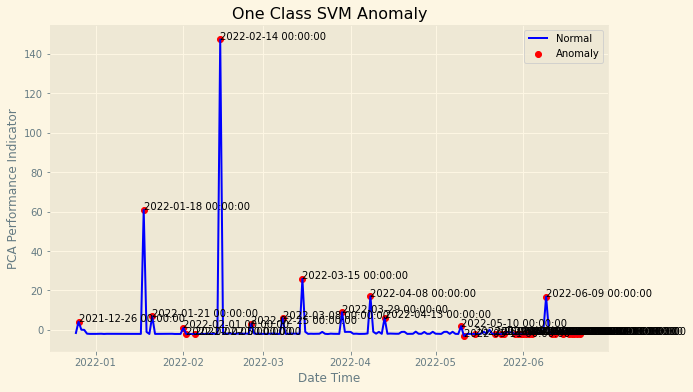

In [12]:
df_plot = df.copy()

df_plot['day'] =  pd.to_datetime(df_plot['day'])
df_plot['anomaly3'] = pd.Series(y_predict)
reduced_data_set[:,0:1].shape
df_plot['comp1'] = reduced_data_set[:,0:1];
# df_plot['comp1'] = pd.Series(reduced_data_set[:,0:1])
#df_plot.head()

print ( np.unique(y_predict, return_counts=True))

fig, ax = plt.subplots(figsize=(10,6))
a = df_plot.loc[df_plot['anomaly3'] == -1, ['day', 'comp1']] #anomaly

ax.plot(df_plot['day'], df_plot['comp1'], color='blue', label ='Normal')
ax.scatter(a['day'],a['comp1'], color='red', label = 'Anomaly')
for index, row in a.iterrows():
    day = row['day']
    comp1 = row['comp1']
    plt.text(day, comp1 , day)
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('PCA Performance Indicator')
plt.title('One Class SVM Anomaly')
plt.savefig("./images/oneClassSVMAnomaly_"+data+".png")
plt.show();

### K-Means Number of Cluster evaluation (1-10)

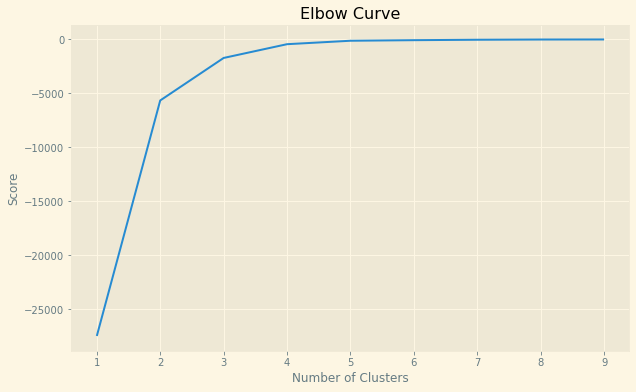

In [13]:
evaluateClustersKMeans(reduced_data_set)

### K-Means with 3 clusters for anomaly detection

In [14]:
km = KMeans(n_clusters=3)
km.fit(reduced_data_set)
y_predict_km=km.predict(reduced_data_set)
df_plot['anomaly4'] = pd.Series(y_predict_km)
print ( np.unique(y_predict_km, return_counts=True))
# df_plot.head()

(array([0, 1, 2], dtype=int32), array([175,   1,   4]))


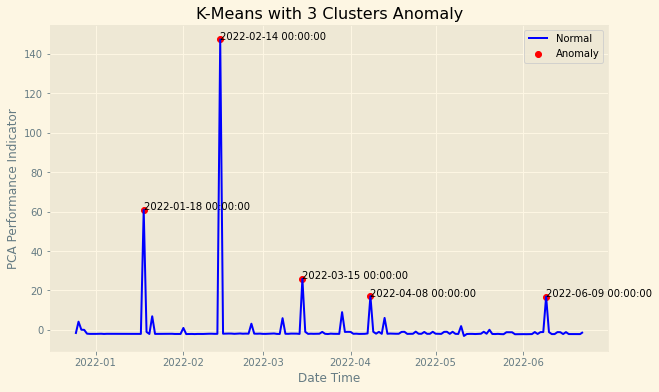

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
a = df_plot.loc[(df_plot['anomaly4'] > 0), ['day', 'comp1']] #anomaly

ax.plot(df_plot['day'], df_plot['comp1'], color='blue', label ='Normal')
ax.scatter(a['day'],a['comp1'], color='red', label = 'Anomaly')
plt.legend()
for index, row in a.iterrows():
    day = row['day']
    comp1 = row['comp1']
    plt.text(day, comp1 , day)
plt.xlabel('Date Time')
plt.ylabel('PCA Performance Indicator')
plt.title('K-Means with 3 Clusters Anomaly')
plt.savefig("./images/kmeansAnomaly_"+data+".png")
plt.show();

### TimeSeries Decomposition to find Trends, Seasonality and Residual

/Users/nramarajar/opt/anaconda3/envs/Project/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


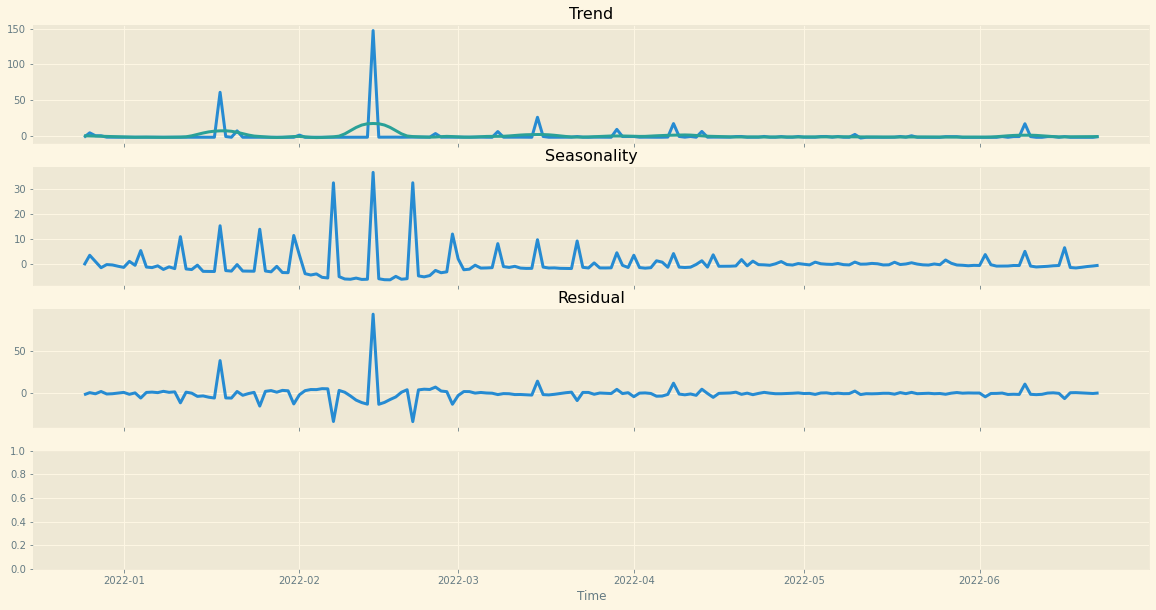

In [16]:
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.consts import TimeSeriesData

df_pca1 = df_pca.copy()
df_pca1['value'] = df_pca1['comp1']
columns_to_drop = componentList
df_pca1 = df_pca1.drop(columns_to_drop, axis=1)

timeseries = TimeSeriesData(df_pca1)

decomposer = TimeSeriesDecomposition(timeseries, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()
plt.savefig("./images/timeSeriesDecomposition_"+data+".png")

### Using OutlierDetection for finding anomaly

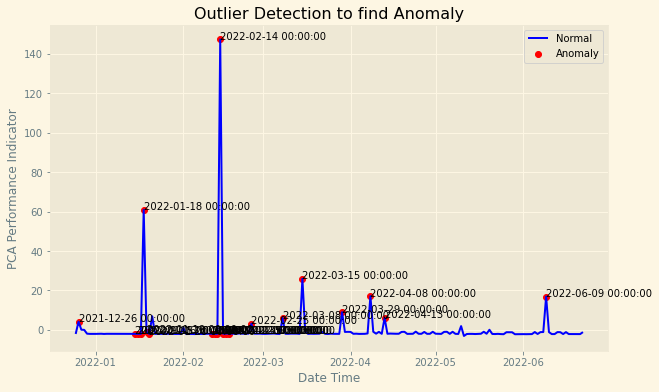

In [17]:
from kats.detectors.outlier import OutlierDetector
tsd = TimeSeriesData(df_pca1)
ts_outlierDetection = OutlierDetector(tsd)
ts_outlierDetection.detector()

df_plot['anomaly5'] = np.where(df_plot['day'].isin(ts_outlierDetection.outliers[0]), 0, 1)

fig, ax = plt.subplots(figsize=(10,6))
#df['hasimage'] = np.where(df['photos']!= '[]', True, False)
# a = df_plot.loc[(df_plot['anomaly4'] > 0) |  (df_plot['anomaly4'] > 1), ['day', 'comp1']] #anomaly
a = df_plot[df_plot['day'].isin(ts_outlierDetection.outliers[0])]
ax.plot(df_plot['day'], df_plot['comp1'], color='blue', label ='Normal')
ax.scatter(a['day'],a['comp1'], color='red', label = 'Anomaly')
plt.legend()
for index, row in a.iterrows():
    day = row['day']
    comp1 = row['comp1']
    plt.text(day, comp1 , day)
plt.xlabel('Date Time')
plt.ylabel('PCA Performance Indicator')
plt.title('Outlier Detection to find Anomaly')
plt.savefig("./images/outlierDetection_"+data+".png")
plt.show();

### Using IsolationForest for finding anomaly

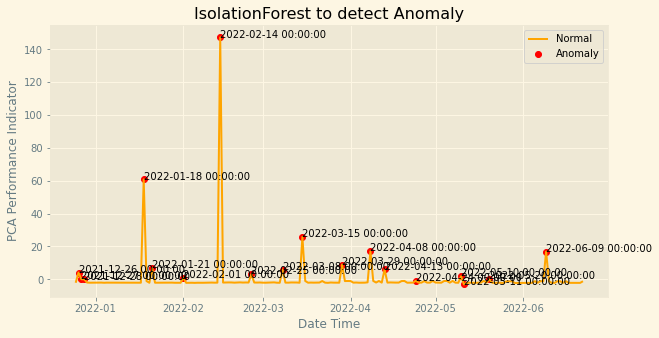

In [18]:
from sklearn.ensemble import IsolationForest
def doIsolationForest(dataset):
    # Isolation forest 
    outliers_fraction = 0.1
    ifo = IsolationForest(contamination = outliers_fraction)
    ifo.fit(reduced_data_set)
    df_plot['anomaly_if'] = pd.Series(ifo.predict(dataset))
    fig, ax = plt.subplots(figsize = (10, 5))
    a = df_plot.loc[df_plot['anomaly_if'] == -1, ['day', 'comp1']]
    ax.plot(df_plot['day'], df_plot['comp1'], 
            color = 'orange', label = 'Normal')
    ax.scatter(a['day'], a['comp1'], 
               color = 'red', label = 'Anomaly')
    plt.legend()
    for index, row in a.iterrows():
        day = row['day']
        comp1 = row['comp1']
        plt.text(day, comp1 , day)
    plt.xlabel('Date Time')
    plt.ylabel('PCA Performance Indicator')
    plt.title('IsolationForest to detect Anomaly')
    plt.savefig("./images/IsolationForest_"+data+".png")
    plt.show();
    
doIsolationForest(reduced_data_set)

### Using DBSCAN for anomaly detection

(array([-1,  0,  1,  2,  3]), array([ 10, 163,   3,   2,   2]))


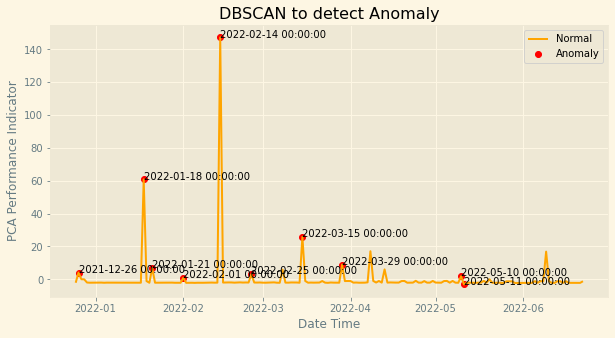

In [19]:
from sklearn.cluster import DBSCAN
def doDBSCAN(dataset):
    dbscan = DBSCAN(eps=0.6, min_samples=2)
    dbscan_result = dbscan.fit_predict(dataset)
    return dbscan_result

dbscan_result = doDBSCAN(reduced_data_set);
df_plot['anomaly_dbscan'] = pd.Series(dbscan_result)
print ( np.unique(dbscan_result, return_counts=True))
fig, ax = plt.subplots(figsize = (10, 5))
a = df_plot.loc[df_plot['anomaly_dbscan'] == -1, ['day', 'comp1']]
ax.plot(df_plot['day'], df_plot['comp1'], 
        color = 'orange', label = 'Normal')
ax.scatter(a['day'], a['comp1'], 
           color = 'red', label = 'Anomaly')

plt.xlabel('Date Time')
plt.ylabel('PCA Performance Indicator')
plt.title('DBSCAN to detect Anomaly')
for index, row in a.iterrows():
    day = row['day']
    comp1 = row['comp1']
    plt.text(day, comp1 , day)
plt.savefig("./images/dbscan_"+data+".png")
plt.legend()
plt.show();

In [20]:
df_plot['anomaly_all'] = 0
df_plot['anomaly_all'] = np.where(df_plot['anomaly3'] == -1, df_plot['anomaly_all']+1, df_plot['anomaly_all'])
df_plot['anomaly_all'] = np.where(df_plot['anomaly4'] > 0, df_plot['anomaly_all']+1, df_plot['anomaly_all'])
df_plot['anomaly_all'] = np.where(df_plot['anomaly5'] == 0, df_plot['anomaly_all']+1, df_plot['anomaly_all'])
df_plot['anomaly_all'] = np.where(df_plot['anomaly_if'] == -1, df_plot['anomaly_all']+1, df_plot['anomaly_all'])
df_plot['anomaly_all'] = np.where(df_plot['anomaly_dbscan'] == -1, df_plot['anomaly_all']+1, df_plot['anomaly_all'])
df_plot.head()

,day,BTS_ID,RRC_Conn_Release_due_to_S1_Link_Fail,Max_Num_RRC_Conn_User,Mean_RRC_Conn_Setup_Time_ms,Avg_PRACH_Usage_per_Second,FDD_Cell_DL_Avg_Agg_Thruput_Mbps,FDD_Cell_UL_Avg_Agg_Thruput_Mbps,FDD_Cell_DL_MAC_Data_Volume_MB,FDD_Cell_UL_MAC_Data_Volume_MB,...,RSSI_Avg_dBm,PRACH_Avg_NI_dBm,Power_DL_Avg_mw,anomaly3,comp1,anomaly4,anomaly5,anomaly_if,anomaly_dbscan,anomaly_all
0,2021-12-25,10-1,0.0,19.958333,19.348333,0.301516,11.912083,1.735000,60166.510694,9419.933505,...,-93.110924,-118.887211,18962.708333,1,-2.074616,0,1,1,0,0
1,2021-12-26,10-1,6.0,24.833333,24.294667,0.391527,12.189583,1.614583,70854.092318,9254.511008,...,-88.954724,-118.932611,21639.854167,-1,4.150052,0,0,-1,-1,4
2,2021-12-27,10-1,2.0,27.000000,28.200542,0.445115,10.920833,1.607917,48500.813883,7955.694856,...,-94.315949,-119.035074,18058.406250,1,0.078195,0,1,-1,1,1
3,2021-12-28,10-1,2.0,23.458333,24.006000,0.407824,11.974583,1.593333,68838.418306,9636.230181,...,-92.026000,-118.881102,23262.114583,1,0.007456,0,1,-1,1,1
4,2021-12-29,10-1,0.0,24.583333,26.159042,0.459953,11.141667,1.597917,65559.198244,9458.242858,...,-92.946943,-119.008148,22972.489583,1,-1.938135,0,1,1,0,0


In [21]:
df_plot['anomaly_all'].unique()

array([0, 4, 1, 5, 3])

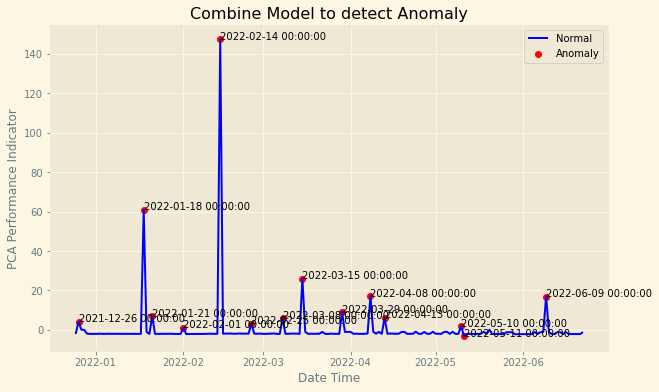

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
a = df_plot.loc[df_plot['anomaly_all'] > 2, ['day', 'comp1']] #anomaly
ax.plot(df_plot['day'], df_plot['comp1'], color='blue', label ='Normal')
ax.scatter(a['day'],a['comp1'], color='red', label = 'Anomaly')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('PCA Performance Indicator')
plt.title('Combine Model to detect Anomaly')
for index, row in a.iterrows():
    day = row['day']
    comp1 = row['comp1']
    plt.text(day, comp1 , day)


plt.savefig("./images/MaxAnomalyInAllModel_"+data+".png")
plt.show();